In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

#### Load data

In [92]:
env_air_df = pd.read_parquet('../data/processed/air_quality_hotspot_data-20241101_20241130.parquet')

#### Merge environment and satellite hotspot data

In [133]:
# limit date range
avg_env_air_df = env_air_df.reset_index()
avg_env_air_df = avg_env_air_df[
(avg_env_air_df['date']>='2024-11-27 00:00:00+00:00') & \
(avg_env_air_df['date']<='2024-11-30 23:59:59+00:00')].set_index(['date','latitude','longitude'])

# set momdel variables
X = avg_env_air_df[[c for c in avg_env_air_df.columns if c not in ['pm10','pm2_5','carbon_monoxide','nitrogen_dioxide','sulphur_dioxide','ozone','dust']]]
y = avg_env_air_df[['pm2_5']]
X.shape, y.shape

# split data for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [135]:
avg_env_air_df.head()

temperature_2m  \
date                      latitude longitude                   
2024-11-27 00:00:00+00:00 13.5     97.0            29.025000   
                                   97.5            29.116667   
                                   98.0            28.833611   
                                   98.5            25.494556   
                                   99.0            23.422417   

                                              relative_humidity_2m  \
date                      latitude longitude                         
2024-11-27 00:00:00+00:00 13.5     97.0                  79.000000   
                                   97.5                  77.111111   
                                   98.0                  76.111111   
                                   98.5                  82.000000   
                                   99.0                  86.833333   

                                              dew_point_2m  pressure_msl  \
date                      latitude longitude                               
2024-11-27 00:00:00+00:00 13.5     97.0          25.010119   1008.883333   
                                   97.5          24.690775   1008.900000   
                                   98.0          24.175060   1009.011111   
                                   98.5          22.129526   1009.511111   
                                   99.0          21.088330   1011.466667   

                                              surface_pressure  \
date                      latitude longitude                     
2024-11-27 00:00:00+00:00 13.5     97.0            1008.883333   
                                   97.5            1008.900000   
                                   98.0            1008.286400   
                                   98.5             994.585992   
                                   99.0             957.570497   

                                              wind_speed_10m  wind_speed_80m  \
date                      latitude longitude                                   
2024-11-27 00:00:00+00:00 13.5     97.0            12.704918       13.690346   
                                   97.5            11.135305       11.840362   
                                   98.0             8.066002        8.828166   
                                   98.5             4.522302        7.719153   
                                   99.0             6.192225       13.471537   

                                              wind_speed_120m  \
date                      latitude longitude                    
2024-11-27 00:00:00+00:00 13.5     97.0             13.807564   
                                   97.5             12.032958   
                                   98.0              9.396125   
                                   98.5              9.396093   
                                   99.0             15.376810   

                                              wind_speed_180m  \
date                      latitude longitude                    
2024-11-27 00:00:00+00:00 13.5     97.0             14.328325   
                                   97.5             12.810662   
                                   98.0             10.285702   
                                   98.5             12.049599   
                                   99.0             17.698177   

                                              wind_direction_10m  ...  \
date                      latitude longitude                      ...   
2024-11-27 00:00:00+00:00 13.5     97.0                74.424132  ...   
                                   97.5                70.858981  ...   
                                   98.0                71.296404  ...   
                                   98.5                70.777036  ...   
                                   99.0                54.735457  ...   

                                              temperature_180m      pm10  \
date                      latitude longitude     

In [137]:
X.head(2).T

date                 2024-11-27 00:00:00+00:00             
latitude                                  13.5             
longitude                                 97.0         97.5
temperature_2m                       29.025000    29.116667
relative_humidity_2m                 79.000000    77.111111
dew_point_2m                         25.010119    24.690775
pressure_msl                       1008.883333  1008.900000
surface_pressure                   1008.883333  1008.900000
wind_speed_10m                       12.704918    11.135305
wind_speed_80m                       13.690346    11.840362
wind_speed_120m                      13.807564    12.032958
wind_speed_180m                      14.328325    12.810662
wind_direction_10m                   74.424132    70.858981
wind_direction_80m                   75.569497    71.680042
wind_direction_120m                  75.664400    71.915674
wind_direction_180m                  76.284500    73.527509
temperature_80m                      28.066667    28.177778
temperature_120m                     27.416667    27.500000
temperature_180m                     26.616667    26.788889
uv_index                              0.100000     0.150000
hotspot_num                           3.000000     3.000000

In [139]:
X.info(), y.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 25920 entries, (Timestamp('2024-11-27 00:00:00+0000', tz='UTC'), 13.5, 97.0) to (Timestamp('2024-11-30 23:00:00+0000', tz='UTC'), 20.5, 105.5)
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temperature_2m        25920 non-null  float64
 1   relative_humidity_2m  25920 non-null  float64
 2   dew_point_2m          25920 non-null  float64
 3   pressure_msl          25920 non-null  float64
 4   surface_pressure      25920 non-null  float64
 5   wind_speed_10m        25920 non-null  float64
 6   wind_speed_80m        25920 non-null  float64
 7   wind_speed_120m       25920 non-null  float64
 8   wind_speed_180m       25920 non-null  float64
 9   wind_direction_10m    25920 non-null  float64
 10  wind_direction_80m    25920 non-null  float64
 11  wind_direction_120m   25920 non-null  float64
 12  wind_direction_180m   25920 non-null  float64
 13  temp

(None, None)

In [141]:
# initialize XGBoost model
model = xgb.XGBRFRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(root_mean_squared_error(y_test, preds))

4.096864199204979


#### Review matrix

In [144]:
model.score(X_test, y_test)

0.5905122756958008

In [88]:
y_test.describe()

,pm2_5
count,38880.000000
mean,12.900328
std,7.478906
min,0.200000
25%,7.966667
50%,11.550000
75%,16.100000
max,73.350000


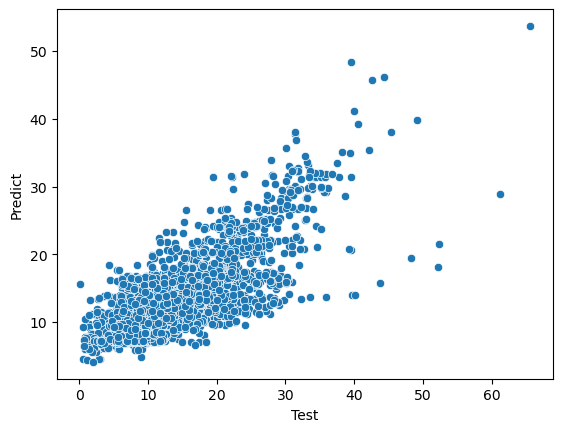

In [147]:
# plot test vs. predict
sns.scatterplot(x=pd.Series(y_test.values[:,-1]), y=pd.Series(preds));
plt.xlabel('Test')
plt.ylabel('Predict')
plt.show()

#### Other Models...